
# S&P 500 Price Movement Prediction Using Logistic Regression

## Project Overview
This project aims to predict the daily price movement (up or down) of the S&P 500 index using historical price data and technical indicators. We frame this as a binary classification problem, where the target variable indicates whether the closing price the next day is higher (1) or lower (0) than the current day.

## Motivation
Financial markets generate vast amounts of data, and predicting price movements is a core challenge in quantitative finance. By leveraging classic technical indicators and logistic regression, we explore a simple but interpretable approach to forecasting short-term price trends.

## Data Source
- **Ticker:** ^GSPC (S&P 500 Index)  
- **Data Provider:** Yahoo Finance via `yfinance` Python library  
- **Period:** January 1, 2023 – July 31, 2025


## Features Used
| Feature Name           | Description                                      | Lookback Window (days)  |
|-----------------------|------------------------------------------------|------------------------|
| Daily Return          | Percentage price change from previous day       | 1                      |
| 5-day Moving Average  | Average close price over the past 5 days        | 5                      |
| 10-day Moving Average | Average close price over the past 10 days       | 10                     |
| Momentum (5-day)      | Difference between today’s and 5 days ago close | 5                      |
| Rolling Std Dev (10-day) | Standard deviation of close prices over 10 days | 10                     |
| Average True Range (ATR) | Measure of volatility over 14 days             | 14                     |
| Relative Strength Index (RSI) | Momentum oscillator over 14 days           | 14                     |
| Lagged Return (1-day) | Previous day’s return                            | 1                      |
| MACD                  | Moving Average Convergence Divergence indicator | 26 (slow EMA)  |

## Tools & Libraries
- Python 3.x
- pandas for data manipulation
- yfinance for downloading financial data
- ta for technical indicator calculations
- scikit-learn for model training and evaluation
- matplotlib / seaborn for data visualization

## Workflow
- Download and preprocess historical price data.
- Compute technical indicator features.
- Define the target variable.
- plit data into training and test sets.
- Scale features for model compatibility.
- Train a logistic regression model.
- Evaluate model performance.
- Visualize results.


## Import libraries
We start by importing the necessary Python libraries for data handling, visualization, and machine learning.


In [1]:
import yfinance as yf 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Load and Explore the Data  
We download historical daily data for the S&P 500 index (^GSPC) using the yfinance library. The first five rows will be printed as a preview of the data.

In [2]:
df = yf.download('^GSPC', start='2023-01-01', end='2025-07-31', multi_level_index=False)
print(f"Shape: {df.shape}")
df.head()



/var/folders/sd/317t7m5n15974yrthr25jyx80000gn/T/ipykernel_84973/717480921.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('^GSPC', start='2023-01-01', end='2025-07-31', multi_level_index=False)
[*********************100%***********************]  1 of 1 completed

Shape: (645, 5)


,Close,High,Low,Open,Volume
Date,,,,,
2023-01-03,3824.139893,3878.459961,3794.330078,3853.290039,3959140000
2023-01-04,3852.969971,3873.159912,3815.770020,3840.360107,4414080000
2023-01-05,3808.100098,3839.739990,3802.419922,3839.739990,3893450000
2023-01-06,3895.080078,3906.189941,3809.560059,3823.370117,3923560000
2023-01-09,3892.090088,3950.570068,3890.419922,3910.820068,4311770000


## Obtain the Features
We will use nine technical indicators as features for our model. These indicators are commonly used in financial analysis to capture trends, momentum, and volatility in the market.

In [3]:
# 1. Daily Return (percentage change from previous day)
df['Daily_Return'] = df['Close'].pct_change()

# 2. 5-day Moving Average
df['MA_5'] = df['Close'].rolling(window=5).mean()

# 3. 10-day Moving Average
df['MA_10'] = df['Close'].rolling(window=10).mean()


# 4. Momentum (5-day difference)
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)

# 5. Rolling Std Dev (10-day)
df['Rolling_STD_10'] = df['Close'].rolling(window=10).std()

# 6. Average True Range (ATR 14-day)
atr = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14, fillna=True)
df['ATR_14'] = atr.average_true_range()


# 7. Relative Strength Index (RSI 14-day)
rsi = RSIIndicator(close=df['Close'], window=14)
df['RSI_14'] = rsi.rsi()


# 8. Lagged Return (1-day)
df['Lagged_Return_1'] = df['Daily_Return'].shift(1)

# 9. MACD (12, 26, 9)
exp12 = df['Close'].ewm(span=12, adjust=False).mean()
exp26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp12 - exp26


## Create the Target Variable column

We define the target variable to indicate whether the price will increase the next day.  The target is set to 1 if the next day’s closing price is higher than today’s, and 0 otherwise. This helps frame our problem as a binary classification task. The first 5 rows are printed will all the features and the target variable.

In [4]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.head()

,Close,High,Low,Open,Volume,Daily_Return,MA_5,MA_10,Momentum_5,Rolling_STD_10,ATR_14,RSI_14,Lagged_Return_1,MACD,Target
Date,,,,,,,,,,,,,,,
2023-01-03,3824.139893,3878.459961,3794.330078,3853.290039,3959140000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.000000,1
2023-01-04,3852.969971,3873.159912,3815.770020,3840.360107,4414080000,0.007539,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.299835,0
2023-01-05,3808.100098,3839.739990,3802.419922,3839.739990,3893450000,-0.011646,NaN,NaN,NaN,NaN,0.0,NaN,0.007539,0.496129,1
2023-01-06,3895.080078,3906.189941,3809.560059,3823.370117,3923560000,0.022841,NaN,NaN,NaN,NaN,0.0,NaN,-0.011646,6.015888,0
2023-01-09,3892.090088,3950.570068,3890.419922,3910.820068,4311770000,-0.000768,3854.476025,NaN,NaN,NaN,0.0,NaN,0.022841,10.033411,1


## Handling Missing Values

Some indicators require a certain number of past days to compute (like moving averages or RSI), which results in `NaN` values for the initial rows.  
To ensure our dataset is clean and ready for modeling, we drop all rows containing any missing values.

In [5]:
df.dropna(inplace=True)
df.head()

,Close,High,Low,Open,Volume,Daily_Return,MA_5,MA_10,Momentum_5,Rolling_STD_10,ATR_14,RSI_14,Lagged_Return_1,MACD,Target
Date,,,,,,,,,,,,,,,
2023-01-23,4019.810059,4039.310059,3971.639893,3978.139893,3945210000,0.011881,3962.220068,3957.431055,20.719971,44.432169,61.759260,69.398977,0.018918,40.319314,0
2023-01-24,4016.949951,4023.919922,3989.790039,4001.739990,3320430000,-0.000712,3967.416064,3969.917041,25.979980,41.475585,59.785733,68.769874,0.011881,43.411360,0
2023-01-25,4016.219971,4019.550049,3949.060059,3982.709961,3724020000,-0.000182,3984.888037,3979.614038,87.359863,39.607115,60.550323,68.598951,-0.000712,45.280954,1
2023-01-26,4060.429932,4061.570068,4013.290039,4036.080078,3809590000,0.011008,4017.204004,3988.696021,161.579834,46.815024,59.673873,72.979153,-0.000182,49.756434,1
2023-01-27,4070.560059,4094.209961,4048.699951,4053.719971,3907760000,0.002495,4036.793994,3997.435034,97.949951,53.366966,58.662169,73.878300,0.011008,53.503941,0


## Splitting the Data into Training and Testing Sets

We split the dataset chronologically to preserve the time series order.  
- The **training set** includes data from 1 January  2023 to 31 of December 2024.  
- The **testing set** includes data from 1 January 2025 to 31 July 2025.

This way, the model is trained on past data and tested on future unseen data, which mimics real-world forecasting scenarios.


In [6]:
# Define date ranges for training and testing
train_start = '2023-01-01'
train_end = '2024-12-31'
test_start = '2025-01-01'
test_end = '2025-07-31'

# Split the DataFrame by date
train_df = df.loc[train_start:train_end]
test_df = df.loc[test_start:test_end]

# Check shapes
print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)



Training data shape: (489, 15)
Testing data shape: (143, 15)


## Feature Selection and Dataset Preparation

We select the nine engineered indicators as our input features for the model. These include momentum, volatility, and trend indicators calculated earlier. We then extract these features along with the target variable into NumPy arrays for compatibility with the scikit-learn library.


In [7]:
# Select the columns that will be the features
feature_columns = [
    'Daily_Return', 'MA_5', 'MA_10', 'Momentum_5', 'Rolling_STD_10', 
    'ATR_14', 'RSI_14', 'Lagged_Return_1', 'MACD'
]

# Extract these columns as a NumPy array
X_train = train_df[feature_columns].to_numpy()
y_train = train_df['Target'].to_numpy()
X_test = test_df[feature_columns].to_numpy()
y_test = test_df["Target"].to_numpy()


## Visualizing Individual Features Against the Target
We plot each feature against the target variable to explore potential relationships and patterns. Although it’s challenging to identify clear trends by examining each feature in isolation, this step provides a useful initial insight before building a combined predictive model.

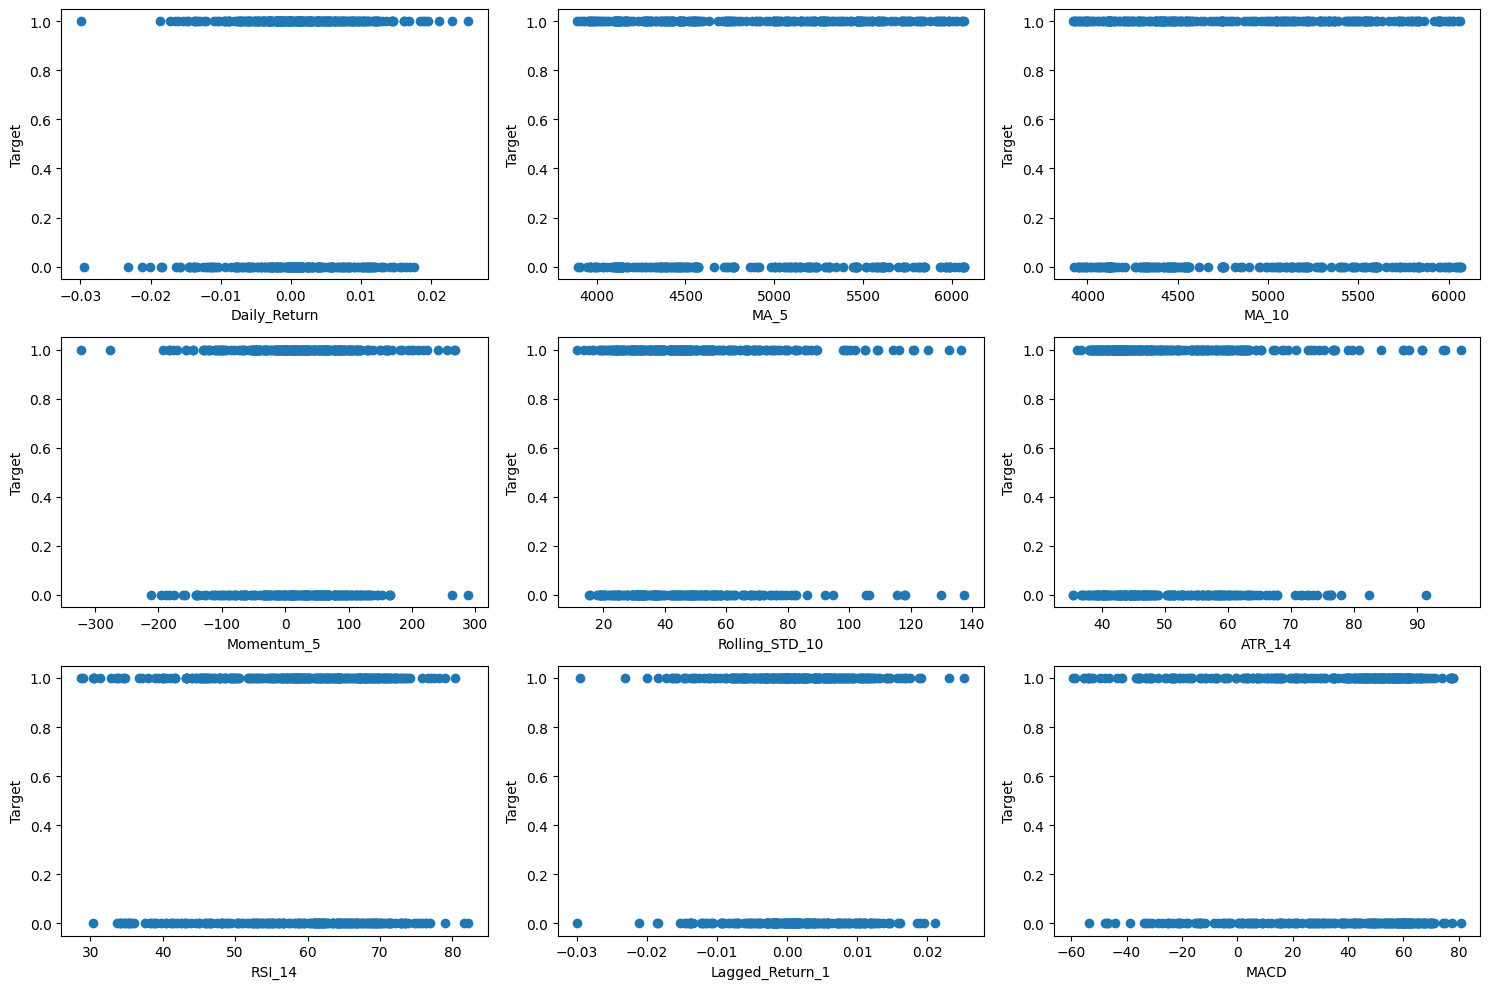

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(len(feature_columns)):
    axes[i].scatter(X_train[:, i], y_train)
    axes[i].set_xlabel(feature_columns[i])
    axes[i].set_ylabel("Target")
    

plt.tight_layout()
plt.show()

After visualizing each feature individually against the target variable, it is difficult to identify clear or strong patterns that separate upward and downward price movements. However, combining all features together into a single predictive model may uncover more complex relationships and improve pattern recognition.

## Correlation Heatmap

To better understand the relationships between the features and the target variable, we will visualize their correlations using a heatmap. This helps identify which features are strongly positively or negatively correlated with the target.

We will use the **Seaborn** library to create a visually appealing and easy-to-interpret heatmap of the correlation matrix.


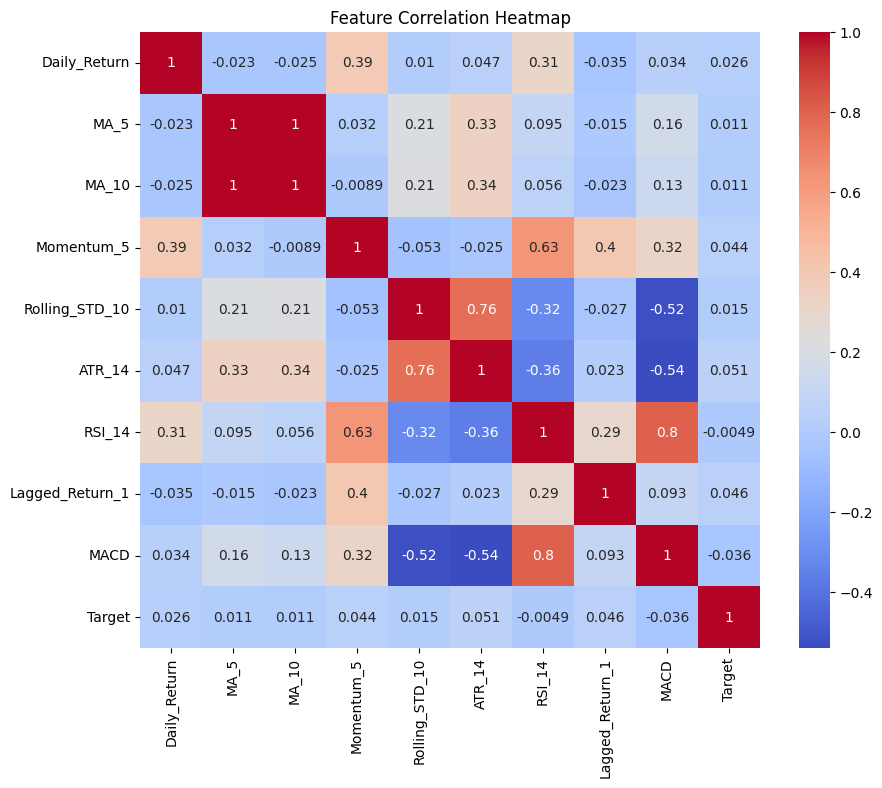

In [11]:
corr_columns = feature_columns + ['Target']  

# Compute correlation matrix for the features and target columns
corr_matrix = df[corr_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

### Highly correlated features:
- `MA_5` and `MA_10` have a perfect correlation of 1.0, meaning they provide very similar information.
- `Rolling_STD_10` and `ATR_14` have a strong positive correlation (0.76), as both measure volatility.
- `RSI_14` and `MACD` show a strong positive correlation (0.80), indicating these momentum indicators tend to move together.

### Features with moderate correlation to the target:
Most features have a low correlation with the Target variable, with values close to zero (between -0.005 and 0.05). This suggests that individually, these features have limited predictive power for the binary target (price increase or decrease).

### Insights:
- The strong correlations among some features suggest potential redundancy, so some features might be combined or reduced in future modeling (e.g., via dimensionality reduction techniques).
- The weak correlation between features and target emphasizes the importance of combining multiple features in the model, as single features may not suffice for accurate prediction.


## Feature Scaling
We scale the features using standardization, which transforms each feature to have a mean of 0 and a standard deviation of 1. This helps gradient descent converge more efficiently and improves the model’s learning. The scaler is fit only on the training data to avoid data leakage. Then, the same scaler is applied to transform the test data, ensuring consistency between training and testing features.

In [21]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaler to the testing data
X_test_scaled = scaler.transform(X_test)
print(f"X_train_scaled:{X_train_scaled[:5]}")
print(f"X_test_scaled:{X_test_scaled[:5]}")


X_train_scaled:[[ 1.38089884e+00 -1.43221067e+00 -1.42941868e+00  2.02270120e-03
  -1.80598939e-01  9.07371955e-01  9.99497194e-01  2.24393212e+00
   2.95881756e-01]
 [-1.93302094e-01 -1.42405927e+00 -1.40975121e+00  6.29393841e-02
  -3.12441540e-01  7.33553704e-01  9.43278824e-01  1.36842968e+00
   3.87108438e-01]
 [-1.27075843e-01 -1.39664951e+00 -1.39447685e+00  7.73785756e-01
  -3.95761997e-01  8.00894899e-01  9.28004703e-01 -1.98286450e-01
   4.42268328e-01]
 [ 1.27170582e+00 -1.34595272e+00 -1.38017124e+00  1.63333443e+00
  -7.43405808e-02  7.23701666e-01  1.31943149e+00 -1.32375082e-01
   5.74311405e-01]
 [ 2.07515087e-01 -1.31522024e+00 -1.36640586e+00  8.96430590e-01
   2.17829395e-01  6.34595857e-01  1.39978175e+00  1.25975583e+00
   6.84876596e-01]]
X_test_scaled:[[-0.38236143  1.65969109  1.68553695 -2.22398231  0.84781705  1.63123604
  -1.62076482 -0.64285168 -1.31322102]
 [ 1.47023945  1.62984665  1.69661194 -1.33952693  0.68235945  1.69925537
  -0.91477478 -0.38644687 -1

As you can see, after scaling, the feature values now approximately range between -2 and 2.

## Train Logistic Regression and Evaluate Model Performance

In this step, we train a logistic regression model on the training data using the scaled features. After training, we use the model to predict the market movement on the test set and evaluate its performance.

We will examine key classification metrics such as accuracy, precision, recall, F1-score, and visualize the confusion matrix to understand how well the model distinguishes between price increases (1) and decreases (0).


In [23]:
# Initialize logistic regression model
log_reg = LogisticRegression()

# Fit the model on training data
log_reg.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5594

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.17      0.24        60
           1       0.58      0.84      0.69        83

    accuracy                           0.56       143
   macro avg       0.51      0.51      0.47       143
weighted avg       0.52      0.56      0.50       143


Confusion Matrix:
[[10 50]
 [13 70]]


## Model Evaluation and Interpretation

After training the logistic regression model, we evaluate its performance on the test set using several metrics: **accuracy**, **precision**, **recall**, **F1-score**, and the **confusion matrix**. These metrics give us a comprehensive view of how well the model is predicting whether the S&P 500 price will go up (1) or down (0).

### Key Metrics Explained:

- **Accuracy (0.56):**  
  The model correctly predicts the market movement about 56% of the time. While better than random guessing (50%), this accuracy indicates there is room for improvement.

- **Precision:**  
  Precision tells us, out of all the times the model predicted a class (up or down), how many were actually correct.  
  - Class 0 (price down): Precision is 0.43 — when the model predicts a down day, it is correct 43% of the time.  
  - Class 1 (price up): Precision is 0.58 — when the model predicts an up day, it is correct 58% of the time.

- **Recall:**  
  Recall measures how well the model identifies all actual instances of a class.  
  - Class 0: Recall is 0.17 — the model only identifies 17% of actual down days.  
  - Class 1: Recall is 0.84 — the model correctly identifies 84% of actual up days.

- **F1-score:**  
  The F1-score is the harmonic mean of precision and recall, balancing the two.  
  - Class 0: 0.24 (low, showing poor performance on down days)  
  - Class 1: 0.69 (better, showing reasonable performance on up days)

- **Support:**  
  The number of actual occurrences of each class in the test set: 60 down days and 83 up days.

### Confusion Matrix Interpretation:

|                | Predicted Down (0) | Predicted Up (1) |
|----------------|--------------------|------------------|
| Actual Down (0) | 10                 | 50               |
| Actual Up (1)   | 13                 | 70               |

- The model correctly predicted 10 down days but misclassified 50 down days as up days.  
- For up days, it correctly predicted 70 and misclassified 13 as down days.

### Summary:

The model is more effective at predicting days when the price will go up, but struggles with correctly identifying down days, as indicated by the low recall and F1-score for class 0. This imbalance suggests the model may be biased towards the majority class (price up) or that features need improvement to better capture signals for price drops.
